In [1]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

from typing import List, Optional, Iterable, Union, Dict

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import copy
from itertools import combinations

from numba import cuda

from warnings import filterwarnings
filterwarnings('ignore')

import pickle

In [2]:
def preprocess(df_features_or: pd.DataFrame,
               labels=None,
               features_to_keep: Optional[Iterable[str]] = None,
               lagged_features: Optional[Union[Iterable[str],Dict[str, Iterable[str]]]] = None,
               fillna: Optional[str] = None,
               circular_weekofyear: bool = False,
               feature_lags=None,
               label_lags=None):
    '''
    Add lagged features or target values as needed, accounting for existence of two cities in dataset.
    fillna: Fill NaN approach, e.g. 'ffill'. None to not fill.
    '''

    df_features = df_features_or.copy()
    df_features = df_features.reset_index()

    if features_to_keep is not None:         # Filter features
        feature_names = features_to_keep + ['city']
        df_features = df_features[feature_names]
    else:
        feature_names = list(df_features.columns)

    if fillna is not None:                   # Fill NaNs
        df_features.fillna(method=fillna, inplace=True)

    # Convert city feature to categorical and one hot encode
    df_features["city"] = df_features["city"].astype("category")
    df_features = pd.get_dummies(df_features, columns=['city'], drop_first=True)

    # Create circular week of year. #TEMP: update again
    if circular_weekofyear:
        # df_features['weekofyear1'] = np.sin((df_features['weekofyear']-1)/51*2*np.pi)
        # df_features['weekofyear2'] = np.cos((df_features['weekofyear']-1)/51*2*np.pi)
        # df_features.drop(columns=['weekofyear'],inplace=True)
        df_features['weekofyear'] = np.sin((df_features['weekofyear']-1)/51*np.pi)
        
    # Split cities before adding lags
    sj_features = df_features[df_features['city_sj']]
    iq_features = df_features[~df_features['city_sj']]

    if labels is not None:
        sj_labels = labels[df_features['city_sj']]
        iq_labels = labels[~df_features['city_sj']]
    else:
        sj_labels = None        
        iq_labels = None

    # Lagged feature/labels creation
    if (lagged_features is not None) or (label_lags is not None):
        # Add lagged features
        if isinstance(lagged_features,dict):                # Do individual lags for different features
            for feat, feat_lags in lagged_features.items():
                sj_features_lagged = sj_features[feat].shift(periods=feat_lags)
                sj_features = pd.concat([sj_features,sj_features_lagged],axis=1)
                iq_features_lagged = iq_features[feat].shift(periods=feat_lags)
                iq_features = pd.concat([iq_features,iq_features_lagged],axis=1)
        elif isinstance(lagged_features, (list, tuple)):    # All considered features has same lags
            for feat in lagged_features:
                if 'total_cases' in feat:                   # Skip all total_cases features, used when preprocessing pred features
                    continue
                sj_features_lagged = sj_features[feat].shift(periods=feature_lags)
                sj_features = pd.concat([sj_features,sj_features_lagged],axis=1)
                iq_features_lagged = iq_features[feat].shift(periods=feature_lags)
                iq_features = pd.concat([iq_features,iq_features_lagged],axis=1)

        # Add lagged labels
        if label_lags is not None:
            sj_lagged_labels = sj_labels.shift(periods=label_lags)
            sj_features = pd.concat([sj_features,sj_lagged_labels],axis=1)
            iq_lagged_labels = iq_labels.shift(periods=label_lags)
            iq_features = pd.concat([iq_features,iq_lagged_labels],axis=1)
  
    return sj_features, iq_features, sj_labels, iq_labels

# # Pre-process data
# def preprocess(df_features_or,features_to_keep,lagged_features,feature_lags=None,is_label_lagged=False,label_lags=None,labels=None):
#     df_features = df_features_or.copy()
#     df_features = df_features.reset_index()
#     feature_names = features_to_keep + ['city','weekofyear']
#     df_features = df_features[feature_names]

#     df_features.fillna(method='ffill', inplace=True)

#     # Convert to categorical and one hot encode
#     df_features["city"] = df_features["city"].astype("category")
#     df_features = pd.get_dummies(df_features, columns=['city'], drop_first=True)

#     # Create circular week of year
#     df_features['weekofyear'] = np.sin((df_features['weekofyear']-1)/51*np.pi)
    
#     # Add lagged features
#     if feature_lags is not None:
#         for feat in lagged_features:
#             df_lagged_feat = df_features[feat].shift(periods=feature_lags)
#             df_features = pd.concat([df_features,df_lagged_feat],axis=1)

#     # Add lagged labels
#     if is_label_lagged:
#         df_lagged_labels = labels.shift(periods=label_lags)
#         df_features = pd.concat([df_features,df_lagged_labels],axis=1)
        
#     return df_features

# def modelfit(alg, X_train, y_train, useTrainCV=True, cv_folds=5, early_stopping_rounds=50,trainCV_metrics = 'mae',
#              eval_metric = 'mae',report_metric =  metrics.mean_absolute_error, verbose=True,
#              weights=None, feature_weights = None):

#     if useTrainCV:
#         xgb_param = alg.get_xgb_params()
#         xgtrain = xgb.DMatrix(X_train, label=y_train,feature_weights=feature_weights)
#         xgtrain.set_info(feature_weights=feature_weights)

#         if weights is not None:
#             xgtrain.set_weight(weights)

#         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics=trainCV_metrics, early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
#         alg.set_params(n_estimators=cvresult.shape[0])
    
#     #Fit the algorithm on the data
#     # alg.fit(X_train, y_train, eval_metric=eval_metric, feature_weights=feature_weights)
#     alg.fit(X_train, y_train, feature_weights=feature_weights)
        
#     #Predict training set:
#     X_train_predictions = alg.predict(X_train)
        
#     #Print model report:
#     if verbose:
#         print("\nModel Report")
#         print(report_metric)
#         print(report_metric(y_train, X_train_predictions))
                    

def modelfit(alg, X_train, y_train, useTrainCV=True, cv_folds=5, early_stopping_rounds=50,trainCV_metrics = 'mae',
             eval_metric = 'mae',report_metric =  metrics.mean_absolute_error, verbose=True,
             weights=None, feature_weights = None):
    '''
    Automatically fit model, with option for using CV to get best n_estimators
    alg: XGBoost model
    weights: Weights for each data point
    feature_weights: Weights for each feature. Used here to reduce weights on lagged labels to reduce reliance on it.
    '''

    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(X_train, label=y_train,feature_weights=feature_weights)
    xgtrain.set_info(feature_weights=feature_weights)

    if weights is not None:
        xgtrain.set_weight(weights)

    if useTrainCV:
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=trainCV_metrics, early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, feature_weights=feature_weights)
        
    #Predict training set:
    X_train_predictions = alg.predict(X_train)
        
    #Print model report:
    if verbose:
        print("\nModel Report")
        print(report_metric)
        print(report_metric(y_train, X_train_predictions))


# def create_XGBmodel(eta=0.01,n_estimators=1000,
#                     max_depth=5,objective='reg:squarederror',**kwargs):
#     return xgb.XGBRegressor(
#         learning_rate =eta,
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         min_child_weight=1.02,
#         gamma=0.51,
#         subsample=0.86,
#         colsample_bytree=0.84,
#         objective= objective,
#         scale_pos_weight=1,
#         seed=42,
#         **kwargs)

def create_XGBmodel(eta=0.01,n_estimators=1000,
                    max_depth=5,objective='reg:squarederror',
                    min_child_weight=1.02, gamma=0.51, subsample=0.86,
                    colsample_bytree=0.84, scale_pos_weight=1, seed=42,
                    **kwargs):
    '''
    Create an XGBRegressor model based on availability of GPU
    '''

    try:
        cuda.detect()
        gpu_available = cuda.is_available()
    except:
        gpu_available = False

    if gpu_available:
        return xgb.XGBRegressor(
            tree_method= 'gpu_hist',  # Use GPU accelerated algorithm
            n_gpus=1,
            device='cuda:0',
            learning_rate =eta,
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            gamma=gamma,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            objective= objective,
            scale_pos_weight=scale_pos_weight,
            seed=seed,
            **kwargs)
    else:
        return xgb.XGBRegressor(
            learning_rate =eta,
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            gamma=gamma,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            objective= objective,
            scale_pos_weight=scale_pos_weight,
            seed=seed,
            **kwargs)
    

def get_predictions(model, X_val, label_lags, is_label_lagged=False,MC=None):
    if is_label_lagged:
        if MC is None:
            X_val_no_lags = X_val.copy()
            lag_label_col_names = ['total_cases_'+str(lag) for lag in label_lags]
            lag_label_col_locs = [X_val_no_lags.columns.get_loc(col) for col in lag_label_col_names]

            pred_val = np.zeros(X_val_no_lags.shape[0])
            for i in range(X_val_no_lags.shape[0]):
                pred_val[i] = model.predict(X_val_no_lags.iloc[i:i+1,:])                  # Predict current value, keep input in required dataframe format
                for k,j in enumerate(label_lags):                                           # Add predicted value to X_val as lagged labels for subsequent rows
                    try:
                        X_val_no_lags.iloc[i+j,lag_label_col_locs[k]] = pred_val[i]
                    except:
                        continue
        else:
            X_val_no_lags = X_val.copy()
            lag_label_col_names = ['total_cases_'+str(lag) for lag in label_lags]
            lag_label_col_locs = [X_val_no_lags.columns.get_loc(col) for col in lag_label_col_names]
            pred_val = np.zeros([X_val_no_lags.shape[0],MC])

            for l in range(MC):
                X_val_no_lags = X_val.copy()
                
                if l%20==0:
                    print(f'Step {l} of {MC} MC simulations')
                for i in range(X_val_no_lags.shape[0]):
                    lambda_ = model.predict(X_val_no_lags.iloc[i:i+1,:])                         # Get poisson lambda parameter
                    pred_val[i,l] = np.random.poisson(lambda_)                                   # Predict current value by taking a sample
                    for k,j in enumerate(label_lags):                                            # Add predicted value to X_val as lagged labels for subsequent rows
                        try:
                            X_val_no_lags.iloc[i+j,lag_label_col_locs[k]] = pred_val[i,l]
                        except:
                            continue
    else:
        pred_val = model.predict(X_val)
    pred_val = np.round(pred_val)
    pred_val = np.clip(pred_val, 0, 10000000)
    
    return pred_val

def eval_and_plot(model,X_train,y_train,X_val,y_val,
                  is_label_lagged=False,label_lags=None,
                  plot=True,verbose=True, MC=None,sd_gauss = None):
    pred_train = model.predict(X_train)
    pred_train = np.round(pred_train)
    pred_train = np.clip(pred_train, 0, 10000000)
    
    train_mae = mean_absolute_error(y_train, pred_train)
    if verbose:
        print("Train MAE:", train_mae)

    pred_val = get_predictions(model, X_val, label_lags, is_label_lagged=is_label_lagged,MC=MC)

    if MC is None:
        val_mae = mean_absolute_error(y_val, pred_val)
    else:
        val_mae = mean_absolute_error(y_val, np.mean(pred_val,axis=1))
    if verbose:
        print("Val MAE:", val_mae)

    if plot:
        fig, axs = plt.subplots(1,2,figsize=(8,3))
        fig2, axs2 = plt.subplots(2,1,figsize=(10,6))
        axs[0].scatter(y_train, pred_train)
        pred_train = pd.Series(pred_train, index=y_train.index)
        axs2[0].plot(np.arange(len(pred_train)), pred_train.sort_index(),marker='.',label='pred');
        axs2[0].plot(np.arange(len(y_train)), y_train.sort_index(),marker='.',label='y');
        axs2[0].legend();
        axs2[0].set_title(f'Training MAE: {train_mae}')


        if MC is None:
            axs[1].scatter(y_val, pred_val)
            pred_val = pd.Series(pred_val, index=y_val.index)
            axs2[1].plot(np.arange(len(pred_val)), pred_val.sort_index(),marker='.',label='pred');
            axs2[1].plot(np.arange(len(y_val)), y_val.sort_index(),marker='.',label='y');
            axs2[1].legend();
            axs2[1].set_title(f'Validation MAE: {val_mae}')
        else:
            axs[1].scatter(y_val, np.mean(pred_val,axis=1))
                        
            for l in range(MC):
                axs2[1].plot(np.arange(pred_val.shape[0]), pred_val[:,l],alpha=0.2,color='grey');
            axs2[1].plot(np.arange(pred_val.shape[0]), np.mean(pred_val,axis=1),color='red');                
            axs2[1].plot(np.arange(len(y_val)), y_val.sort_index(),color='k',marker='.');
        
    return pred_train, pred_val, train_mae, val_mae

In [3]:
# Load the provided data
train_features_or = pd.read_csv('./data/dengue_features_train.csv',
                             index_col=[1,2])
test_features_or = pd.read_csv('./data/dengue_features_test.csv',
                             index_col=[1,2])
test_features_aug_or = pd.read_csv('./data/dengue_features_test2.csv',
                             index_col=[1,2])
train_labels = pd.read_csv('./data/dengue_labels_train.csv',
                           index_col=[1,2])
train_labels = train_labels.reset_index()
train_labels.drop(columns=['city','year','weekofyear'],inplace=True)

temp_feature_names = [col for col in train_features_or.columns if col not in ['week_start_date','city']]

In [4]:
def prep_data(label_lags=[2,3], feature_lags=[2,3], folds=6, fold_size=0.15):
    lagged_features = temp_feature_names
    train_features = preprocess(train_features_or,temp_feature_names,
                                lagged_features,feature_lags,is_label_lagged=True,label_lags=label_lags,labels=train_labels)
    test_features = preprocess(test_features_or,temp_feature_names,
                            lagged_features,feature_lags,is_label_lagged=False)

    sj_mask = train_features['city_sj']
    iq_mask = ~sj_mask
    sj_train_features = train_features.copy().loc[sj_mask,[col for col in train_features.columns if col != 'city_sj']]
    iq_train_features = train_features.copy().loc[iq_mask,[col for col in train_features.columns if col != 'city_sj']]

    sj_train_labels = train_labels[sj_mask]
    iq_train_labels = train_labels[iq_mask]

    # K-fold with sequential splits, 6 folds, with early data kept out
    X_train_sj, X_val_sj, y_train_sj, y_val_sj = [], [], [], []
    X_train_iq, X_val_iq, y_train_iq, y_val_iq = [], [], [], []
    sj_size = len(sj_train_features)
    iq_size = len(iq_train_features)
    sj_fold_size = round(fold_size*sj_size)
    iq_fold_size = round(fold_size*iq_size)
    sj_train_features_temp = sj_train_features.copy()
    iq_train_features_temp = iq_train_features.copy()
    sj_train_labels_temp = sj_train_labels.copy()
    iq_train_labels_temp = iq_train_labels.copy()

    for _ in range(folds):
        # Add to X_val
        X_val_sj.append(sj_train_features_temp.iloc[-sj_fold_size:,:])
        sj_train_features_temp.drop(sj_train_features_temp.index[-sj_fold_size:],inplace=True)
        X_val_iq.append(iq_train_features_temp.iloc[-iq_fold_size:,:])
        iq_train_features_temp.drop(iq_train_features_temp.index[-iq_fold_size:],inplace=True)
        
        # Add to y_val
        y_val_sj.append(sj_train_labels_temp.iloc[-sj_fold_size:,:])
        sj_train_labels_temp.drop(sj_train_labels_temp.index[-sj_fold_size:],inplace=True)
        y_val_iq.append(iq_train_labels_temp.iloc[-iq_fold_size:,:])
        iq_train_labels_temp.drop(iq_train_labels_temp.index[-iq_fold_size:],inplace=True)

    # Create X_train and y_train
    X_train_sj_components = copy.deepcopy(X_val_sj)
    X_train_iq_components = copy.deepcopy(X_val_iq)
    y_train_sj_components = copy.deepcopy(y_val_sj)
    y_train_iq_components = copy.deepcopy(y_val_iq)

    for i in range(folds):
        X_train_sj_components_temp = copy.deepcopy(X_train_sj_components)
        X_train_sj_components_temp.pop(i)
        X_train_sj_components_temp.append(copy.deepcopy(sj_train_features_temp))  # Remove 1 fold, add back remainder rows from earlier
        X_train_sj.append(pd.concat(X_train_sj_components_temp))

        y_train_sj_components_temp = copy.deepcopy(y_train_sj_components)
        y_train_sj_components_temp.pop(i)
        y_train_sj_components_temp.append(copy.deepcopy(sj_train_labels_temp))  # Remove 1 fold, add back remainder rows from earlier
        y_train_sj.append(pd.concat(y_train_sj_components_temp))

        X_train_iq_components_temp = copy.deepcopy(X_train_iq_components)
        X_train_iq_components_temp.pop(i)
        X_train_iq_components_temp.append(copy.deepcopy(iq_train_features_temp))  # Remove 1 fold, add back remainder rows from earlier
        X_train_iq.append(pd.concat(X_train_iq_components_temp))

        y_train_iq_components_temp = copy.deepcopy(y_train_iq_components)
        y_train_iq_components_temp.pop(i)
        y_train_iq_components_temp.append(copy.deepcopy(iq_train_labels_temp))  # Remove 1 fold, add back remainder rows from earlier
        y_train_iq.append(pd.concat(y_train_iq_components_temp))

    return X_train_sj, X_val_sj, y_train_sj, y_val_sj, X_train_iq, X_val_iq, y_train_iq, y_val_iq

Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 4080 SUPER'                              [SUPPORTED]
                      Compute Capability: 8.9
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-f1d5998d-eba4-9052-500d-4444204ecda3
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 64
Summary:
	1/1 devices are supported
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100.   1.   1.]
45
Index(['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm',
       'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent',

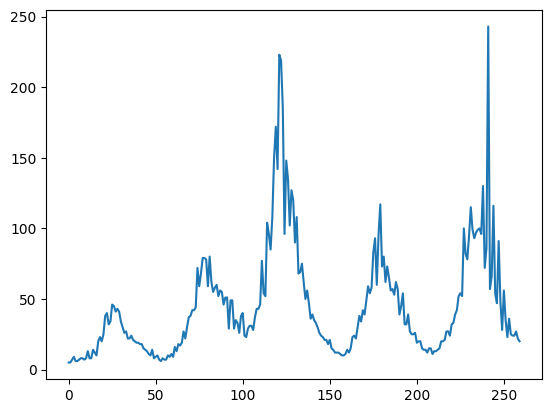

In [61]:
# sj training data
label_lags=(3,4,)
feature_lags=(3,)
feature_names = [col for col in train_features_or.columns if col not in ['week_start_date','city','year']]+['weekofyear']
lagged_features = feature_names

# Preprocess to get lagged features/labels
sj_train_features, iq_features, sj_train_labels, iq_labels = preprocess(train_features_or,labels=train_labels,
                                                            features_to_keep = feature_names,
                                                            lagged_features = lagged_features,
                                                            fillna = 'ffill', feature_lags=feature_lags,
                                                            label_lags=label_lags,circular_weekofyear=True)

feature_weights = 100*np.ones(sj_train_features.shape[1])
feature_weights[-len(label_lags):] =1

# Drop city column if training cities separately
sj_train_features.drop(columns=['city_sj','weekofyear_3'],inplace=True)

lagged_label_names = ['total_cases_'+str(i) for i in label_lags]


sj_pred_features_aug, _, _, _ = preprocess(test_features_aug_or,
                                  features_to_keep = feature_names + lagged_label_names,
                                  lagged_features = lagged_features,
                                  fillna = 'ffill', feature_lags=feature_lags,
                                  label_lags=None,circular_weekofyear=True)
sj_pred_features_aug.drop(columns='weekofyear_3',inplace=True)

sj_mask = sj_pred_features_aug['city_sj']
iq_mask = ~sj_mask
sj_pred_features_aug = sj_pred_features_aug.copy().loc[sj_mask,[col for col in sj_pred_features_aug.columns if col != 'city_sj']]
order_needed = sj_train_features.columns.to_list()
sj_pred_features_aug = sj_pred_features_aug[order_needed]

xg_reg_sj = create_XGBmodel(eta=0.01,n_estimators=500,max_depth=5,
                            objective='reg:squarederror',
                            reg_alpha=1,reg_lambda=1)

print(feature_weights)
print(len(feature_weights))
print(sj_train_features.columns)
print(sj_train_features.shape)

modelfit(xg_reg_sj, sj_train_features, sj_train_labels,
         useTrainCV=True, cv_folds=5, early_stopping_rounds=50,
         trainCV_metrics = 'mae', eval_metric = 'mae',
         report_metric = metrics.mean_absolute_error,
         feature_weights=feature_weights)
        
sj_pred_val = get_predictions(xg_reg_sj,sj_pred_features_aug,
                              label_lags,is_label_lagged=True,MC=None)

pred_sj = np.round(sj_pred_val).astype('int')
plt.plot(pred_sj)

In [6]:
sj_train_features.to_csv('sj_train_features_old2.csv',index=None)
sj_train_labels.to_csv('sj_train_labels_old2.csv',index=None)
sj_pred_features_aug.to_csv('sj_pred_features_old2.csv',index=None)

Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 4080 SUPER'                              [SUPPORTED]
                      Compute Capability: 8.9
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-f1d5998d-eba4-9052-500d-4444204ecda3
                                Watchdog: Enabled
             FP32/FP64 Performance Ratio: 64
Summary:
	1/1 devices are supported
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100.   1.   1.]
45
Index(['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm',
       'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent',

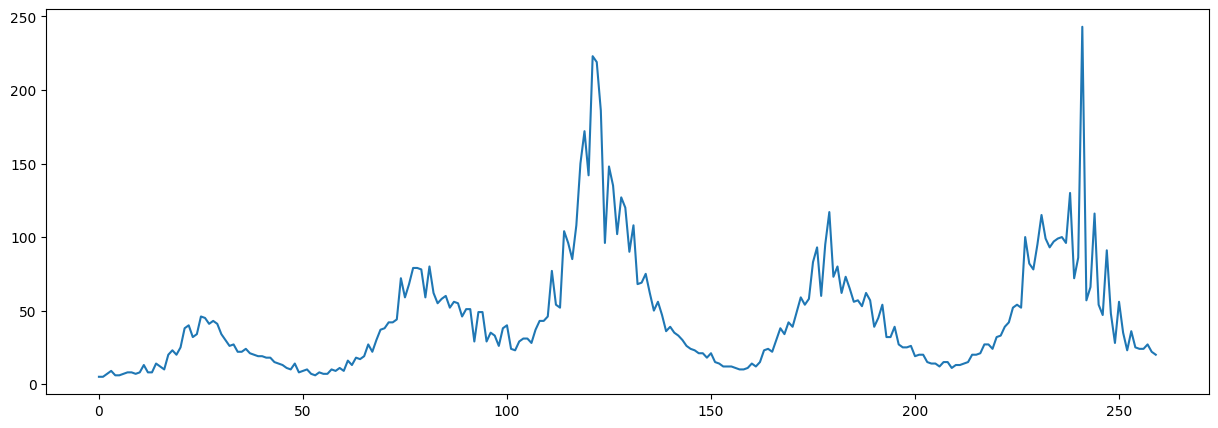

In [63]:
# Specify modelling parameters
label_lags=(3,4,)
feature_lags = (3,)
feature_names = [col for col in train_features_or.columns if col not in ['week_start_date','city','year']]+['weekofyear']
lagged_features = feature_names

# Preprocess to get lagged features/labels
sj_features, iq_features, sj_labels, iq_labels = preprocess(train_features_or,labels=train_labels,
                                                            features_to_keep = feature_names,
                                                            lagged_features = lagged_features,
                                                            fillna = 'ffill', feature_lags=feature_lags,
                                                            label_lags=label_lags,circular_weekofyear=True)

feature_weights = 100*np.ones(sj_features.shape[1])
feature_weights[-len(label_lags):] =1

# Drop city column if training cities separately
sj_features.drop(columns=['city_sj','weekofyear_3'],inplace=True)

lagged_label_names = ['total_cases_'+str(i) for i in label_lags]
    

sj_pred_features_aug, _, _, _ = preprocess(test_features_aug_or,
                                  features_to_keep = feature_names + lagged_label_names,
                                  lagged_features = lagged_features,
                                  fillna = 'ffill', feature_lags=feature_lags,
                                  label_lags=None,circular_weekofyear=True)
sj_pred_features_aug.drop(columns='weekofyear_3',inplace=True)

sj_mask = sj_pred_features_aug['city_sj']
iq_mask = ~sj_mask
sj_pred_features_aug = sj_pred_features_aug.copy().loc[sj_mask,[col for col in sj_pred_features_aug.columns if col != 'city_sj']]
order_needed = sj_features.columns.to_list()
sj_pred_features_aug = sj_pred_features_aug[order_needed]

model_sj = create_XGBmodel(eta=0.01,n_estimators=500,max_depth=5,
                                     objective='reg:squarederror',
                                     reg_alpha=1,reg_lambda=1)

print(feature_weights)
print(len(feature_weights))
print(sj_features.columns)
print(sj_features.shape)

modelfit(model_sj, sj_features, sj_labels,
        useTrainCV=True, cv_folds=5, early_stopping_rounds=50,
        trainCV_metrics = 'mae', eval_metric = 'mae',
        report_metric = metrics.mean_absolute_error, verbose=True,
        feature_weights=feature_weights)

sj_sub_pred = get_predictions(model_sj, sj_pred_features_aug,
                              label_lags, is_label_lagged=True)

# sj_sub_pred = medfilt(sj_sub_pred,3)


##### NOTE: islabellagged issue, featureweights issue

fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(sj_sub_pred)